# TC-Impact on Met: Weather Stations

Here we search the GSOD for weather stations near TC landfall to assess the impact of TC passage on the surface meteorology. 

The idea is to search for the nearest station that has ALL data present for landfall +/-30 days, and has at least k % completion for j years, and l % completion for the period +/- landfall within that ten-year period 

In [280]:
import ulmo as ul, numpy as np, pandas as pd,TC_Utils as tc, GeneralFunctions as GF, datetime as datetime, matplotlib.pyplot as plt

In [300]:
# Set parameters
minlen=10 # years of observations
minpc=70 # percentage complete over minlen period
maxdist=197 # maximum distance to search away from the TC (radius to 12 m/s wind [Chavas and Emmanuel, 2010])

# Open the obs file (with landfall locations)
# strcture is: ID	YEAR	JD.JD	LAT	LON	GLAT	GLON	ROW	COL	DIST
tcdata=np.loadtxt("/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/LandFall.txt",delimiter="\t",skiprows=1)

# Pull out landfall lat/lon
tclat=tcdata[:,3]; tclon=tcdata[:,4]
# Set the output file name. It will be a log with ID | LAT | LON | STATION ID | Distance
outfile="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/GSOD_Stations.txt"

In [282]:
# Use ulmo to return meta data on ALL stations with data since 1979
all_stations=ul.ncdc.gsod.get_stations(start="1979-01-01 00:00:00")

## Find stations that are close enough to TC landfall (within maxdist) and have SLP & HI data for the TC landfall dat (+/- 30 days)

In [302]:
# Use ulmo-modified code to extract met data for the station nearest the TC landfall
reload(tc)
ids=all_stations.keys() # station codes
latlon=np.array([[all_stations[ii]["latitude"],all_stations[ii]["longitude"]] for ii in ids],dtype=np.float) # coordinates
# Test now by extracting pressure 
outmet=[]
outmet_hit=[]
out_station=[]
dist_used=np.zeros((len(tcdata)))*np.nan
nsuc=0
with open(outfile,"w") as fo:
    
    # Write the header to the output file
    fo.write("YEAR\tMONTH\tDAY\tID\tLAT\tLON\tSTATION_ID\tDIST\n")
    
    for loc in range(len(tcdata)):

        # If all criteria are met, we'll not search any more; initialise to "search"
        dist=GF.haversine_fast(tclat[loc],tclon[loc],latlon[:,0],latlon[:,1],miles=False) # that's the distance
        order=np.argsort(dist)
        nearest=0
        mindist=dist[order[nearest]]
        keep_search=True
        while keep_search and mindist<maxdist:

            # Construct date index for this landfall location
            tc_date=datetime.date(year=int(tcdata[loc,1]),month=1,day=1)+datetime.timedelta(days=tcdata[loc,2]-1)
            tc_st=tc_date-datetime.timedelta(days=30)
            tc_end=tc_date+datetime.timedelta(days=30)

            # Now extract all data for the year (+/-1) of TC landfall for the station closest to landfall location
            startyr=tc_date.year-1; endyr=tc_date.year+1
            alldata,corevars=tc.get_gsod_data("/media/gytm3/WD12TB/GSOD",\
            [ids[order[nearest]],],startyr=int(startyr), endyr=int(endyr), parameters=None)

            # Check we have something!
            if len(corevars)>1:     

                # Compute HI. etc
                corevars["tempC"]=GF.Faren2C(corevars["mean_temp"])
                corevars["dewC"]=GF.Faren2C(corevars["dew_point"])
                corevars["rh"]=GF.dewVp(corevars["dewC"]+273.15)/GF.satVp(corevars["tempC"])*100.            
                corevars["specHum"]=GF.specHum(corevars["tempC"],corevars["rh"],corevars["slp"])
                corevars["hi"]=GF.HeatIndexNWS(corevars["tempC"],corevars["rh"],opt=False,iounit=np.array([0,0]))

                # Check for completion during "hit"
                hit_data=corevars[tc_st:tc_end]

                # Examine pressure and hi
                # Note these ranges should be constrained based on GSOD meta-data
                n_press=np.sum(np.logical_and(hit_data["slp"]<1100,hit_data["slp"]>800))
                n_hi=np.sum(np.logical_and(hit_data["hi"]>-100,hit_data["hi"]<200))

                # Then all data here
                if n_press == 61 and n_hi == 61:
                    outmet.append(corevars)
                    outmet_hit.append(hit_data)
                    dist_used[loc]=dist[order[nearest]]
                    out_station.append(ids[order[nearest]])

                    # End search
                    keep_search=False; print "Found what we're after! [dist=%.1f]" % dist[order[nearest]]
                    nsuc+=1
                    
                    # Write a new line out
                    lout="%.0f\t%.0f\t%.0f\t%.0f\t%.2f\t%.2f\t%s\t%.2f\n" % \
                    (tc_date.year,tc_date.month,tc_date.day,\
                     tcdata[loc,0],tcdata[loc,3],tcdata[loc,4],ids[order[nearest]],dist[order[nearest]])
                    fo.write(lout)

            if keep_search:
                mindist=dist[order[nearest+1]]
                print "Didn't satisfy criteria [dist=%.1f]; moving to distance: %.1f" % \
                    (dist[order[nearest]],mindist)


            nearest+=1  
        print "Finished with loc %.0f" % loc
            





Didn't satisfy criteria [dist=67.8]; moving to distance: 133.0
Didn't satisfy criteria [dist=133.0]; moving to distance: 134.1
Didn't satisfy criteria [dist=134.1]; moving to distance: 214.2
Finished with loc 0
Didn't satisfy criteria [dist=14.5]; moving to distance: 16.4
Didn't satisfy criteria [dist=16.4]; moving to distance: 99.5
Didn't satisfy criteria [dist=99.5]; moving to distance: 103.3
Didn't satisfy criteria [dist=103.3]; moving to distance: 194.2
Didn't satisfy criteria [dist=194.2]; moving to distance: 225.0
Finished with loc 1
Didn't satisfy criteria [dist=57.5]; moving to distance: 89.3
Didn't satisfy criteria [dist=89.3]; moving to distance: 122.7
Didn't satisfy criteria [dist=122.7]; moving to distance: 123.6
Didn't satisfy criteria [dist=123.6]; moving to distance: 159.5
Didn't satisfy criteria [dist=159.5]; moving to distance: 167.5
Didn't satisfy criteria [dist=167.5]; moving to distance: 189.3
Didn't satisfy criteria [dist=189.3]; moving to distance: 218.6
Finished 

Didn't satisfy criteria [dist=140.6]; moving to distance: 140.8
Didn't satisfy criteria [dist=140.8]; moving to distance: 151.5
Didn't satisfy criteria [dist=151.5]; moving to distance: 190.6
Didn't satisfy criteria [dist=190.6]; moving to distance: 198.2
Finished with loc 20
Didn't satisfy criteria [dist=18.6]; moving to distance: 71.5
Didn't satisfy criteria [dist=71.5]; moving to distance: 71.9
Didn't satisfy criteria [dist=71.9]; moving to distance: 90.4
Didn't satisfy criteria [dist=90.4]; moving to distance: 92.1
Didn't satisfy criteria [dist=92.1]; moving to distance: 95.7
Didn't satisfy criteria [dist=95.7]; moving to distance: 98.0
Found what we're after! [dist=98.0]
Finished with loc 21
Didn't satisfy criteria [dist=109.8]; moving to distance: 111.5
Didn't satisfy criteria [dist=111.5]; moving to distance: 120.9
Didn't satisfy criteria [dist=120.9]; moving to distance: 168.9
Didn't satisfy criteria [dist=168.9]; moving to distance: 225.8
Finished with loc 22
Didn't satisfy cr

Didn't satisfy criteria [dist=138.3]; moving to distance: 151.2
Didn't satisfy criteria [dist=151.2]; moving to distance: 153.0
Didn't satisfy criteria [dist=153.0]; moving to distance: 178.3
Didn't satisfy criteria [dist=178.3]; moving to distance: 186.0
Didn't satisfy criteria [dist=186.0]; moving to distance: 187.5
Didn't satisfy criteria [dist=187.5]; moving to distance: 208.9
Finished with loc 34
Didn't satisfy criteria [dist=34.3]; moving to distance: 43.0
Didn't satisfy criteria [dist=43.0]; moving to distance: 52.4
Didn't satisfy criteria [dist=52.4]; moving to distance: 52.4
Didn't satisfy criteria [dist=52.4]; moving to distance: 60.5
Didn't satisfy criteria [dist=60.5]; moving to distance: 60.9
Didn't satisfy criteria [dist=60.9]; moving to distance: 70.0
Didn't satisfy criteria [dist=70.0]; moving to distance: 71.0
Didn't satisfy criteria [dist=71.0]; moving to distance: 72.1
Didn't satisfy criteria [dist=72.1]; moving to distance: 93.3
Didn't satisfy criteria [dist=93.3]; 

Didn't satisfy criteria [dist=111.1]; moving to distance: 124.2
Found what we're after! [dist=124.2]
Finished with loc 56
Didn't satisfy criteria [dist=24.6]; moving to distance: 37.4
Didn't satisfy criteria [dist=37.4]; moving to distance: 59.7
Didn't satisfy criteria [dist=59.7]; moving to distance: 63.9
Didn't satisfy criteria [dist=63.9]; moving to distance: 72.2
Didn't satisfy criteria [dist=72.2]; moving to distance: 84.9
Didn't satisfy criteria [dist=84.9]; moving to distance: 88.3
Didn't satisfy criteria [dist=88.3]; moving to distance: 94.0
Found what we're after! [dist=94.0]
Finished with loc 57
Didn't satisfy criteria [dist=60.0]; moving to distance: 99.5
Didn't satisfy criteria [dist=99.5]; moving to distance: 172.2
Didn't satisfy criteria [dist=172.2]; moving to distance: 184.9
Didn't satisfy criteria [dist=184.9]; moving to distance: 232.7
Finished with loc 58
Didn't satisfy criteria [dist=33.9]; moving to distance: 125.9
Didn't satisfy criteria [dist=125.9]; moving to di

Didn't satisfy criteria [dist=84.9]; moving to distance: 127.2
Didn't satisfy criteria [dist=127.2]; moving to distance: 162.9
Didn't satisfy criteria [dist=162.9]; moving to distance: 165.8
Didn't satisfy criteria [dist=165.8]; moving to distance: 172.0
Didn't satisfy criteria [dist=172.0]; moving to distance: 198.0
Finished with loc 84
Didn't satisfy criteria [dist=38.3]; moving to distance: 39.9
Didn't satisfy criteria [dist=39.9]; moving to distance: 71.3
Didn't satisfy criteria [dist=71.3]; moving to distance: 75.7
Didn't satisfy criteria [dist=75.7]; moving to distance: 76.5
Didn't satisfy criteria [dist=76.5]; moving to distance: 77.5
Didn't satisfy criteria [dist=77.5]; moving to distance: 121.8
Found what we're after! [dist=121.8]
Finished with loc 85
Didn't satisfy criteria [dist=43.2]; moving to distance: 130.8
Didn't satisfy criteria [dist=130.8]; moving to distance: 137.4
Didn't satisfy criteria [dist=137.4]; moving to distance: 151.8
Didn't satisfy criteria [dist=151.8]; 

Didn't satisfy criteria [dist=60.9]; moving to distance: 68.2
Didn't satisfy criteria [dist=68.2]; moving to distance: 79.8
Didn't satisfy criteria [dist=79.8]; moving to distance: 82.1
Didn't satisfy criteria [dist=82.1]; moving to distance: 83.4
Didn't satisfy criteria [dist=83.4]; moving to distance: 87.0
Didn't satisfy criteria [dist=87.0]; moving to distance: 98.4
Didn't satisfy criteria [dist=98.4]; moving to distance: 99.8
Didn't satisfy criteria [dist=99.8]; moving to distance: 105.4
Didn't satisfy criteria [dist=105.4]; moving to distance: 105.8
Didn't satisfy criteria [dist=105.8]; moving to distance: 106.7
Didn't satisfy criteria [dist=106.7]; moving to distance: 107.4
Didn't satisfy criteria [dist=107.4]; moving to distance: 119.0
Didn't satisfy criteria [dist=119.0]; moving to distance: 128.5
Didn't satisfy criteria [dist=128.5]; moving to distance: 131.7
Didn't satisfy criteria [dist=131.7]; moving to distance: 143.6
Didn't satisfy criteria [dist=143.6]; moving to distanc

Didn't satisfy criteria [dist=68.7]; moving to distance: 68.8
Didn't satisfy criteria [dist=68.8]; moving to distance: 68.8
Didn't satisfy criteria [dist=68.8]; moving to distance: 69.1
Didn't satisfy criteria [dist=69.1]; moving to distance: 71.7
Didn't satisfy criteria [dist=71.7]; moving to distance: 71.9
Didn't satisfy criteria [dist=71.9]; moving to distance: 72.2
Didn't satisfy criteria [dist=72.2]; moving to distance: 72.2
Didn't satisfy criteria [dist=72.2]; moving to distance: 73.3
Didn't satisfy criteria [dist=73.3]; moving to distance: 73.8
Didn't satisfy criteria [dist=73.8]; moving to distance: 76.2
Didn't satisfy criteria [dist=76.2]; moving to distance: 76.9
Didn't satisfy criteria [dist=76.9]; moving to distance: 79.9
Didn't satisfy criteria [dist=79.9]; moving to distance: 84.8
Didn't satisfy criteria [dist=84.8]; moving to distance: 85.8
Didn't satisfy criteria [dist=85.8]; moving to distance: 90.0
Didn't satisfy criteria [dist=90.0]; moving to distance: 94.7
Didn't s

Didn't satisfy criteria [dist=91.6]; moving to distance: 91.7
Didn't satisfy criteria [dist=91.7]; moving to distance: 91.9
Didn't satisfy criteria [dist=91.9]; moving to distance: 94.8
Didn't satisfy criteria [dist=94.8]; moving to distance: 95.3
Didn't satisfy criteria [dist=95.3]; moving to distance: 96.2
Didn't satisfy criteria [dist=96.2]; moving to distance: 96.8
Didn't satisfy criteria [dist=96.8]; moving to distance: 108.1
Didn't satisfy criteria [dist=108.1]; moving to distance: 108.5
Didn't satisfy criteria [dist=108.5]; moving to distance: 109.1
Didn't satisfy criteria [dist=109.1]; moving to distance: 111.4
Didn't satisfy criteria [dist=111.4]; moving to distance: 112.9
Didn't satisfy criteria [dist=112.9]; moving to distance: 115.3
Didn't satisfy criteria [dist=115.3]; moving to distance: 125.3
Didn't satisfy criteria [dist=125.3]; moving to distance: 129.2
Didn't satisfy criteria [dist=129.2]; moving to distance: 153.6
Didn't satisfy criteria [dist=153.6]; moving to dista

Didn't satisfy criteria [dist=175.1]; moving to distance: 176.9
Didn't satisfy criteria [dist=176.9]; moving to distance: 178.2
Didn't satisfy criteria [dist=178.2]; moving to distance: 187.4
Didn't satisfy criteria [dist=187.4]; moving to distance: 189.1
Didn't satisfy criteria [dist=189.1]; moving to distance: 190.4
Didn't satisfy criteria [dist=190.4]; moving to distance: 191.3
Didn't satisfy criteria [dist=191.3]; moving to distance: 192.3
Didn't satisfy criteria [dist=192.3]; moving to distance: 193.7
Didn't satisfy criteria [dist=193.7]; moving to distance: 201.6
Finished with loc 137
Didn't satisfy criteria [dist=26.5]; moving to distance: 57.2
Didn't satisfy criteria [dist=57.2]; moving to distance: 58.0
Didn't satisfy criteria [dist=58.0]; moving to distance: 60.0
Didn't satisfy criteria [dist=60.0]; moving to distance: 61.7
Didn't satisfy criteria [dist=61.7]; moving to distance: 70.8
Didn't satisfy criteria [dist=70.8]; moving to distance: 73.5
Didn't satisfy criteria [dist=

Didn't satisfy criteria [dist=130.6]; moving to distance: 130.7
Didn't satisfy criteria [dist=130.7]; moving to distance: 130.7
Didn't satisfy criteria [dist=130.7]; moving to distance: 133.2
Didn't satisfy criteria [dist=133.2]; moving to distance: 137.3
Didn't satisfy criteria [dist=137.3]; moving to distance: 138.3
Didn't satisfy criteria [dist=138.3]; moving to distance: 138.4
Didn't satisfy criteria [dist=138.4]; moving to distance: 143.9
Didn't satisfy criteria [dist=143.9]; moving to distance: 147.2
Didn't satisfy criteria [dist=147.2]; moving to distance: 149.2
Didn't satisfy criteria [dist=149.2]; moving to distance: 157.3
Didn't satisfy criteria [dist=157.3]; moving to distance: 157.3
Didn't satisfy criteria [dist=157.3]; moving to distance: 161.7
Didn't satisfy criteria [dist=161.7]; moving to distance: 162.3
Didn't satisfy criteria [dist=162.3]; moving to distance: 170.4
Didn't satisfy criteria [dist=170.4]; moving to distance: 174.4
Didn't satisfy criteria [dist=174.4]; mo

Didn't satisfy criteria [dist=56.4]; moving to distance: 57.4
Didn't satisfy criteria [dist=57.4]; moving to distance: 57.9
Didn't satisfy criteria [dist=57.9]; moving to distance: 62.2
Didn't satisfy criteria [dist=62.2]; moving to distance: 65.3
Found what we're after! [dist=65.3]
Finished with loc 177
Didn't satisfy criteria [dist=44.1]; moving to distance: 46.9
Didn't satisfy criteria [dist=46.9]; moving to distance: 48.2
Didn't satisfy criteria [dist=48.2]; moving to distance: 50.8
Didn't satisfy criteria [dist=50.8]; moving to distance: 52.2
Didn't satisfy criteria [dist=52.2]; moving to distance: 53.1
Didn't satisfy criteria [dist=53.1]; moving to distance: 58.7
Didn't satisfy criteria [dist=58.7]; moving to distance: 60.0
Didn't satisfy criteria [dist=60.0]; moving to distance: 62.0
Didn't satisfy criteria [dist=62.0]; moving to distance: 62.2
Didn't satisfy criteria [dist=62.2]; moving to distance: 64.4
Didn't satisfy criteria [dist=64.4]; moving to distance: 65.9
Didn't satis

Didn't satisfy criteria [dist=166.5]; moving to distance: 176.6
Didn't satisfy criteria [dist=176.6]; moving to distance: 177.2
Didn't satisfy criteria [dist=177.2]; moving to distance: 184.4
Didn't satisfy criteria [dist=184.4]; moving to distance: 232.1
Finished with loc 181


## Assess the impact of TC passage on the met recorded at these proximate weather stations


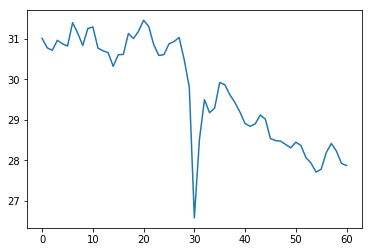

In [299]:
test=np.zeros((106,61))*np.nan
count=0
for ii in outmet_hit:
    test[count,:]=ii["hi"].values[:]; count+=1
plt.plot(np.nanmean(test,axis=0))

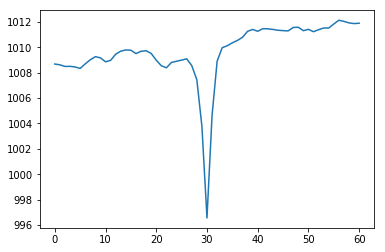

In [298]:
plt.plot(np.nanmean(test,axis=0))